# Analyzing NYC High School Data
in this project we will be exploring the Data and answer some questions
we'll be using data about New York City public schools, which can be found here [links](https://data.cityofnewyork.us/browse?category=Education).

One of the most controversial issues in the U.S. educational system is the efficacy of standardized tests, and whether they're unfair to certain groups. Given our prior knowledge of this topic, investigating the correlations between SAT scores and demographics might be an interesting angle to take. We could correlate SAT scores with factors like race, gender, income, and more.

The same website has several related data sets covering demographic information and test scores. Here are the links to all of the data sets we'll be using:

- SAT scores by school - SAT scores for each high school in New York City
- School attendance - Attendance information for each school in New York City
- Class size - Information on class size for each school
- AP test results - Advanced Placement (AP) exam results for each high school (passing an optional AP exam in a particular subject can earn a student college credit in that subject)
- Graduation outcomes - The percentage of students who graduated, and other outcome information
- Demographics - Demographic information for each school
- School survey - Surveys of parents, teachers, and students at each school

## Importing the Data

In [1]:
import pandas as pd
import numpy
import re
import matplotlib.pyplot as plt
data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

## Read in the surveys

In [2]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

## Add DBN columns

In [3]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

## Convert columns to numeric

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

## Condense datasets

In [5]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

## Convert AP scores to numeric

In [6]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

## Combine the datasets

In [7]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

## Add a school district column for mapping

In [8]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

## Find correlations

In [9]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

## Plotting survey correlations

In [10]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

In [11]:
%matplotlib inline


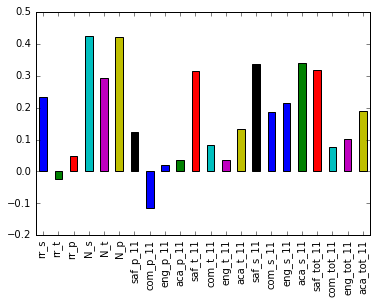

In [12]:
combined.corr()["sat_score"][survey_fields].plot.bar()

### observation
- rr_s and rr_t has postive correlations while the rr_t has negtive correlations.
- n_s , n_t and n_p have very postive correlations .
- overall there is strong postive correlations some few wiith little correlations and we hsve one with strong Negtive correlations com_p_11.

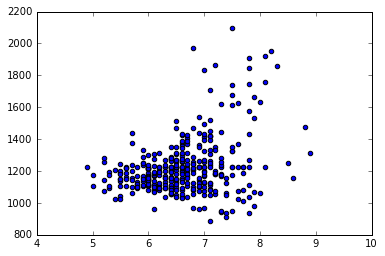

In [13]:
plt.scatter(combined["saf_s_11"],combined["sat_score"])

saf_s_11 there a postive correlations but there more clustered from 1000 to 1500. 


In [14]:
saf_less_8 = combined[(combined["saf_s_11"] < 8)&(combined["sat_score"] < 1500)]

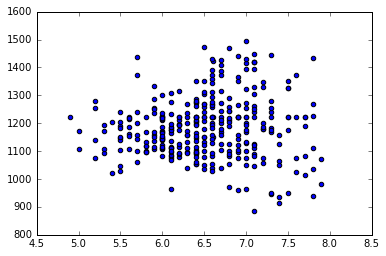

In [15]:
plt.scatter(saf_less_8["saf_s_11"],saf_less_8["sat_score"])

In [16]:
saf_less_8.shape

(333, 160)

In [17]:
combined.shape

(363, 160)

In [18]:
combined.head(15)

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,priority05,priority06,priority07,priority08,priority09,priority10,Location 1,lat,lon,school_dist
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355.0,404.0,363.0,1122.0,0,129.028846,197.038462,...,Then to New York City residents,0,0,0,0,0,"220 Henry Street\nNew York, NY 10002\n(40.7137...",40.713764,-73.985260,01
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383.0,423.0,366.0,1172.0,UNIVERSITY NEIGHBORHOOD H.S.,39.000000,49.000000,...,0,0,0,0,0,0,"200 Monroe Street\nNew York, NY 10002\n(40.712...",40.712332,-73.984797,01
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,377.0,402.0,370.0,1149.0,EAST SIDE COMMUNITY HS,19.000000,21.000000,...,0,0,0,0,0,0,"420 East 12 Street\nNew York, NY 10009\n(40.72...",40.729783,-73.983041,01
3,01M509,MARTA VALLE HIGH SCHOOL,44,390.0,433.0,384.0,1207.0,0,129.028846,197.038462,...,0,0,0,0,0,0,"145 Stanton Street\nNew York, NY 10002\n(40.72...",40.720569,-73.985673,01
4,01M539,"NEW EXPLORATIONS INTO SCIENCE, TECHNOLOGY AND ...",159,522.0,574.0,525.0,1621.0,"NEW EXPLORATIONS SCI,TECH,MATH",255.000000,377.000000,...,0,0,0,0,0,0,"111 Columbia Street\nNew York, NY 10002\n(40.7...",40.718725,-73.979426,01
5,01M696,BARD HIGH SCHOOL EARLY COLLEGE,130,624.0,604.0,628.0,1856.0,0,129.028846,197.038462,...,0,0,0,0,0,0,"525 East Houston Street\nNew York, NY 10002\n(...",40.718962,-73.976066,01
6,02M047,47 THE AMERICAN SIGN LANGUAGE AND ENGLISH SECO...,16,395.0,400.0,387.0,1182.0,0,129.028846,197.038462,...,0,0,0,0,0,0,"223 East 23 Street\nNew York, NY 10010\n(40.73...",40.738599,-73.982512,02
7,02M288,FOOD AND FINANCE HIGH SCHOOL,62,409.0,393.0,392.0,1194.0,0,129.028846,197.038462,...,0,0,0,0,0,0,"525 West 50Th Street\nNew York, NY 10019\n(40....",40.765027,-73.992517,02
8,02M294,ESSEX STREET ACADEMY,53,394.0,384.0,378.0,1156.0,0,129.028846,197.038462,...,0,0,0,0,0,0,"350 Grand Street\nNew York, NY 10002\n(40.7168...",40.716867,-73.989532,02
9,02M296,HIGH SCHOOL OF HOSPITALITY MANAGEMENT,58,374.0,375.0,362.0,1111.0,High School of Hospitality Management,129.028846,197.038462,...,0,0,0,0,0,0,"525 West 50Th Street\nNew York, NY 10019\n(40....",40.765027,-73.992517,02


In [19]:
combined.columns

Index(['DBN', 'SCHOOL NAME', 'Num of SAT Test Takers',
       'SAT Critical Reading Avg. Score', 'SAT Math Avg. Score',
       'SAT Writing Avg. Score', 'sat_score', 'SchoolName', 'AP Test Takers ',
       'Total Exams Taken',
       ...
       'priority05', 'priority06', 'priority07', 'priority08', 'priority09',
       'priority10', 'Location 1', 'lat', 'lon', 'school_dist'],
      dtype='object', length=160)

In [20]:
grouped = combined.groupby("school_dist")
group_mean_school_dist = grouped.mean()
group_mean_school_dist.reset_index(inplace=True)
group_mean_school_dist.head()

,school_dist,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,AP Test Takers,Total Exams Taken,Number of Exams with scores 3 4 or 5,Total Cohort,CSD,...,grade_span_max,expgrade_span_max,zip,total_students,number_programs,priority08,priority09,priority10,lat,lon
0,01,441.833333,473.333333,439.333333,1354.500000,116.681090,173.019231,135.800000,93.500000,1.0,...,12.0,12.0,10003.166667,659.500000,1.333333,0.0,0.0,0.0,40.719022,-73.982377
1,02,426.619092,444.186256,424.832836,1295.638184,128.908454,201.516827,157.495833,158.647849,2.0,...,12.0,12.0,10023.770833,621.395833,1.416667,0.0,0.0,0.0,40.739699,-73.991386
2,03,428.529851,437.997512,426.915672,1293.443035,156.183494,244.522436,193.087500,183.384409,3.0,...,12.0,12.0,10023.750000,717.916667,2.000000,0.0,0.0,0.0,40.781574,-73.977370
3,04,402.142857,416.285714,405.714286,1224.142857,129.016484,183.879121,151.035714,113.857143,4.0,...,12.0,12.0,10029.857143,580.857143,1.142857,0.0,0.0,0.0,40.793449,-73.943215
4,05,427.159915,438.236674,419.666098,1285.062687,85.722527,115.725275,142.464286,143.677419,5.0,...,12.0,12.0,10030.142857,609.857143,1.142857,0.0,0.0,0.0,40.817077,-73.949251


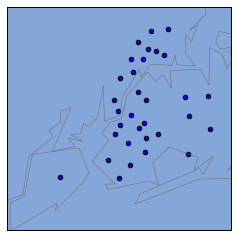

In [21]:
from mpl_toolkits.basemap import Basemap
m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)

longtitude = group_mean_school_dist["lon"].values
latitude = group_mean_school_dist["lat"].values
longtitude,latitude=m(longtitude,latitude)
m.scatter(longtitude,latitude)

## Part 3

In [22]:
race = [  'asian_per','black_per','hispanic_per',"white_per"]
combined


,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,priority05,priority06,priority07,priority08,priority09,priority10,Location 1,lat,lon,school_dist
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355.000000,404.000000,363.000000,1122.000000,0,129.028846,197.038462,...,Then to New York City residents,0,0,0,0,0,"220 Henry Street\nNew York, NY 10002\n(40.7137...",40.713764,-73.985260,01
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383.000000,423.000000,366.000000,1172.000000,UNIVERSITY NEIGHBORHOOD H.S.,39.000000,49.000000,...,0,0,0,0,0,0,"200 Monroe Street\nNew York, NY 10002\n(40.712...",40.712332,-73.984797,01
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,377.000000,402.000000,370.000000,1149.000000,EAST SIDE COMMUNITY HS,19.000000,21.000000,...,0,0,0,0,0,0,"420 East 12 Street\nNew York, NY 10009\n(40.72...",40.729783,-73.983041,01
3,01M509,MARTA VALLE HIGH SCHOOL,44,390.000000,433.000000,384.000000,1207.000000,0,129.028846,197.038462,...,0,0,0,0,0,0,"145 Stanton Street\nNew York, NY 10002\n(40.72...",40.720569,-73.985673,01
4,01M539,"NEW EXPLORATIONS INTO SCIENCE, TECHNOLOGY AND ...",159,522.000000,574.000000,525.000000,1621.000000,"NEW EXPLORATIONS SCI,TECH,MATH",255.000000,377.000000,...,0,0,0,0,0,0,"111 Columbia Street\nNew York, NY 10002\n(40.7...",40.718725,-73.979426,01
5,01M696,BARD HIGH SCHOOL EARLY COLLEGE,130,624.000000,604.000000,628.000000,1856.000000,0,129.028846,197.038462,...,0,0,0,0,0,0,"525 East Houston Street\nNew York, NY 10002\n(...",40.718962,-73.976066,01
6,02M047,47 THE AMERICAN SIGN LANGUAGE AND ENGLISH SECO...,16,395.000000,400.000000,387.000000,1182.000000,0,129.028846,197.038462,...,0,0,0,0,0,0,"223 East 23 Street\nNew York, NY 10010\n(40.73...",40.738599,-73.982512,02
7,02M288,FOOD AND FINANCE HIGH SCHOOL,62,409.000000,393.000000,392.000000,1194.000000,0,129.028846,197.038462,...,0,0,0,0,0,0,"525 West 50Th Street\nNew York, NY 10019\n(40....",40.765027,-73.992517,02
8,02M294,ESSEX STREET ACADEMY,53,394.000000,384.000000,378.000000,1156.000000,0,129.028846,197.038462,...,0,0,0,0,0,0,"350 Grand Street\nNew York, NY 10002\n(40.7168...",40.716867,-73.989532,02
9,02M296,HIGH SCHOOL OF HOSPITALITY MANAGEMENT,58,374.000000,375.000000,362.000000,1111.000000,High School of Hospitality Management,129.028846,197.038462,...,0,0,0,0,0,0,"525 West 50Th Street\nNew York, NY 10019\n(40....",40.765027,-73.992517,02


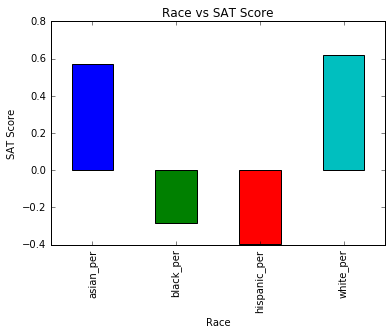

In [23]:
combined.corr()["sat_score"][race].plot.bar()
plt.xlabel("Race")
plt.ylabel("SAT Score")
plt.title("Race vs SAT Score")

### observation
- white_per and asian_per has postive correlations .
- black_per and hispanic_per bith Negtive correlations 
- but we can see the hispanic_per has very high correlations so weill invstigate it furthere.

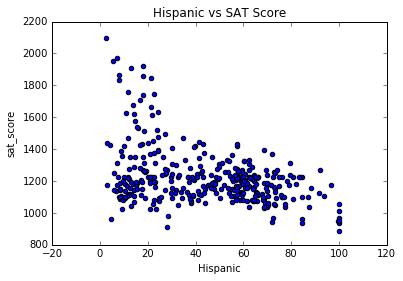

In [24]:
plt.scatter(combined["hispanic_per"],combined["sat_score"])
plt.xlabel("Hispanic")
plt.ylabel("sat_score")
plt.title("Hispanic vs SAT Score")

- we can see that correlations are more in the Negtive Side .

## Hispanic above 95% percent

In [25]:
hispanic_more_95 = combined[combined["hispanic_per"] > 95]
hispanic_more_95["School Name"]

44             MANHATTAN BRIDGES HIGH SCHOOL
82                                         0
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIE
125                                        0
141    INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176                                        0
253                MULTICULTURAL HIGH SCHOOL
286    PAN AMERICAN INTERNATIONAL HIGH SCHOO
Name: School Name, dtype: object

In [26]:
hispanic_more_95

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,priority05,priority06,priority07,priority08,priority09,priority10,Location 1,lat,lon,school_dist
44,02M542,MANHATTAN BRIDGES HIGH SCHOOL,66,336.0,378.0,344.0,1058.0,Manhattan Bridges High School,67.000000,102.000000,...,0,0,0,0,0,0,"525 West 50Th Street\nNew York, NY 10019\n(40....",40.765027,-73.992517,02
82,06M348,WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL,70,380.0,395.0,399.0,1174.0,0,129.028846,197.038462,...,Then to New York City residents,0,0,0,0,0,"511 West 182Nd Street\nNew York, NY 10033\n(40...",40.848879,-73.930807,06
89,06M552,GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...,56,339.0,349.0,326.0,1014.0,GREGORIO LUPERON HS SCI & MATH,88.000000,138.000000,...,0,0,0,0,0,0,"501 West 165Th\nNew York, NY 10032\n(40.838032...",40.838032,-73.938371,06
125,09X365,ACADEMY FOR LANGUAGE AND TECHNOLOGY,54,315.0,339.0,297.0,951.0,Academy for Language and Technology,20.000000,20.000000,...,0,0,0,0,0,0,"1700 Macombs Road\nBronx, NY 10453\n(40.849102...",40.849102,-73.916088,09
141,10X342,INTERNATIONAL SCHOOL FOR LIBERAL ARTS,49,300.0,333.0,301.0,934.0,International School for Liberal Arts,55.000000,73.000000,...,0,0,0,0,0,0,"2780 Reservoir Avenue\nBronx, NY 10468\n(40.87...",40.870377,-73.898163,10
176,12X388,PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE,30,321.0,351.0,298.0,970.0,0,129.028846,197.038462,...,0,0,0,0,0,0,"1300 Boynton Avenue\nBronx, NY 10472\n(40.8313...",40.831366,-73.878823,12
253,19K583,MULTICULTURAL HIGH SCHOOL,29,279.0,322.0,286.0,887.0,Multicultural High School,44.000000,44.000000,...,0,0,0,0,0,0,"999 Jamaica Avenue\nBrooklyn, NY 11208\n(40.69...",40.691144,-73.868426,19
286,24Q296,PAN AMERICAN INTERNATIONAL HIGH SCHOOL,55,317.0,323.0,311.0,951.0,0,129.028846,197.038462,...,0,0,0,0,0,0,"45-10 94Th Street\nElmhurst, NY 11373\n(40.743...",40.743303,-73.870575,24


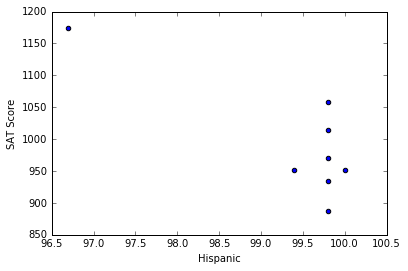

In [27]:
plt.scatter(hispanic_more_95["hispanic_per"],hispanic_more_95["sat_score"])
plt.xlabel("Hispanic")
plt.ylabel("SAT Score")

** Washington Heights Expeditionary Learning School:**

- As of 2012 the school had 600 students; 98% of the students were Hispanic and Latino, with most of them being Dominican American and/or born in the Dominican Republic.[2]

**PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE:**
- Today the network serves approximately 6,000 students annually from 90 countries. Over 90% of students receive free or reduced price lunch, and 86 percent of students come from low-income families. High percentages of students have had interrupted formal education due to political, social, or economic factors in their native countries. 70 percent of students have been separated from one or both parents during their family's immigration to the United States.

**Bell Multicultural High School:**

Students are required to take classes in either Spanish or French with the goal of becoming proficient in that language.[1] All students are required to take two Advanced Placement classes, one in English literature and one in English language.[4] Some students spend part of their school day taking classes at the University of the District of Columbia in pursuit of graduating with both a high school degree and an associate degree.[5]


Members of the BMHS Naval Junior Reserve Officers' Training Corps (NJROTC) color guard unit prepare to take the drill deck at the 15th annual NJROTC Drill Competition on Joint Base Anacostia-Bolling.
In 2008, Newsweek ranked Bell Multicultural the 77th best high school in the United States, and 12th in the D.C. metropolitan area. Newsweek ranked schools by the number of Advanced Placement, International Baccalaureate, and/or Cambridge tests taken by all students at a school in 2007 divided by the number of graduating seniors. Bell Multicultural's ratio was 3.888. It was the only District school to rank in the top 100.[6] In the Washington Post's 2007 Challenge Index, Bell Multicultural was ranked 13th in the region and 319th in the nation.[7]

## Hispanic less 10% and with SAT Score above 1800

In [28]:
his_less_sat_greater = combined[(combined["hispanic_per"] < 10)&(combined["sat_score"] > 1800)]
his_less_sat_greater["School Name"]

37                    STUYVESANT HIGH SCHOOL
151             BRONX HIGH SCHOOL OF SCIENCE
187           BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES A
356      STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: School Name, dtype: object

In [29]:
his_less_sat_greater

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,priority05,priority06,priority07,priority08,priority09,priority10,Location 1,lat,lon,school_dist
37,02M475,STUYVESANT HIGH SCHOOL,832,679.0,735.0,682.0,2096.0,STUYVESANT HS,1510.0,2819.0,...,0,0,0,0,0,0,"345 Chambers Street\nNew York, NY 10282\n(40.7...",40.717746,-74.014049,02
151,10X445,BRONX HIGH SCHOOL OF SCIENCE,731,632.0,688.0,649.0,1969.0,BRONX HS OF SCIENCE,1190.0,2435.0,...,0,0,0,0,0,0,"75 West 205 Street\nBronx, NY 10468\n(40.87705...",40.877056,-73.889780,10
187,13K430,BROOKLYN TECHNICAL HIGH SCHOOL,1277,587.0,659.0,587.0,1833.0,BROOKLYN TECHNICAL HS,2117.0,3692.0,...,0,0,0,0,0,0,"29 Ft Greene Place\nBrooklyn, NY 11217\n(40.68...",40.688107,-73.976745,13
327,28Q687,QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...,121,612.0,660.0,596.0,1868.0,Queens HS for Science York Colllege,215.0,338.0,...,0,0,0,0,0,0,"94-50 159 Street\nJamaica, NY 11433\n(40.70099...",40.700999,-73.798154,28
356,31R605,STATEN ISLAND TECHNICAL HIGH SCHOOL,227,635.0,682.0,636.0,1953.0,STATEN ISLAND TECHNICAL HS,528.0,905.0,...,0,0,0,0,0,0,"485 Clawson Street\nStaten Island, NY 10306\n(...",40.567913,-74.115362,31


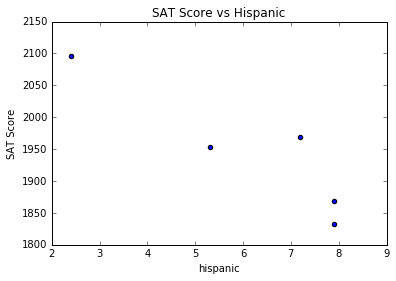

In [30]:
plt.scatter(his_less_sat_greater["hispanic_per"],his_less_sat_greater["sat_score"])
plt.xlabel("hispanic")
plt.ylabel("SAT Score")
plt.title("SAT Score vs Hispanic")

**Specialized high schools in New York City**
- The specialized high schools of New York City are nine selective public high schools, established and run by the New York City Department of Education to serve the needs of academically and artistically gifted students. 
- The Specialized High Schools Admissions Test (SHSAT) examination is required for admission to all the schools except LaGuardia, which requires an audition or portfolio for admission.[1]


Contents
1	The Schools
1.1	The Bronx High School of Science
1.2	Brooklyn Latin School
1.3	Brooklyn Technical High School
1.4	Fiorello H. LaGuardia High School of Music & Art and Performing Arts
1.5	High School for Math, Science and Engineering at City College
1.6	High School of American Studies at Lehman College
1.7	Queens High School for the Sciences at York College
1.8	Staten Island Technical High School
1.9	Stuyvesant High School

**as you can see the schools that we have in dataframe are Speialized High School In New York City**
- so we have brief info about the schools

**Stuyvesant High School:**

Demographics and alleged discrimination.
For most of the 20th century, the student body at Stuyvesant was heavily Jewish. A significant influx of Asian students began in the 1970s; by 2019, 74% of the students in attendance were Asian-American (53% from families with low incomes).[72] In the 2013 academic year, the student body was 72.43% Asian, 21.44% Caucasian, 1.03% African American, 2.34% Hispanic, and 3% unknown/other.[5] The paucity of Black and Hispanic students at Stuyvesant has often been an issue for some city administrators. In 1971, Mayor John Lindsay argued that the test was culturally biased against black and Hispanic students and sought to implement an affirmative action program.[28] However, protests by parents forced the plan to be scrapped and led to the passage of the Hecht-Calandra Act, which preserved admissions by examination only.[73] A small number of students judged to be economically disadvantaged and who come within a few points of the cut-off score were given an extra chance to pass the test.

**Bronx High School of Science**

- Admission to Bronx Science involves passing the Specialized High Schools Admissions Test. Each November, about 30,000 eighth and ninth graders take the three-hour test for admittance to eight of the nine specialized high schools. The test is extremely competitive, with only 900 of the 30,000 applicants being accepted to Bronx Science each year.


**Brooklyn Technical High School:**

- along with Stuyvesant High School and Bronx High School of Science. Brooklyn Tech is considered one of the country's most prestigious and selective public high schools
- Admission to Brooklyn Tech is based exclusively the Specialized High Schools Admissions Test (SHSAT)

**Queens High School for the Sciences**

- It admits students based only on their scores on the Specialized High Schools Admissions Test (commonly referred to as the SHSAT). 

**Staten Island Technical High School**


## part 4

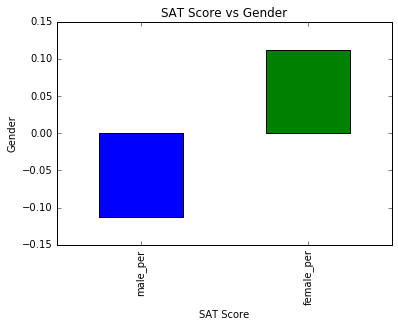

In [31]:
gender = ["male_per","female_per"]
combined.corr()["sat_score"][gender].plot.bar()
plt.xlabel("SAT Score")
plt.ylabel("Gender")
plt.title("SAT Score vs Gender")

### observation
- Male are negitave correlations but women have postive correlations.

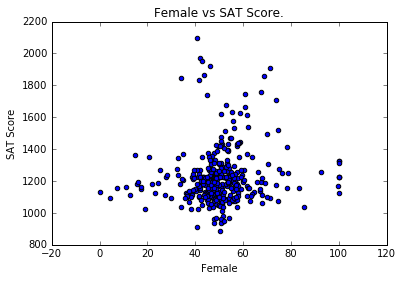

In [32]:
plt.scatter(combined["female_per"],combined["sat_score"])
plt.xlabel("Female")
plt.ylabel("SAT Score")
plt.title("Female vs SAT Score.")

In [33]:
female_less_sat_greater = combined[(combined["female_per"] > 60) & (combined["sat_score"] > 1700)]

In [34]:
female_less_sat_greater

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,priority05,priority06,priority07,priority08,priority09,priority10,Location 1,lat,lon,school_dist
5,01M696,BARD HIGH SCHOOL EARLY COLLEGE,130,624.0,604.0,628.0,1856.0,0,129.028846,197.038462,...,0,0,0,0,0,0,"525 East Houston Street\nNew York, NY 10002\n(...",40.718962,-73.976066,01
26,02M416,ELEANOR ROOSEVELT HIGH SCHOOL,127,572.0,594.0,592.0,1758.0,Eleanor Roosevelt High School,155.000000,235.000000,...,0,0,0,0,0,0,"411 East 76 Street\nNew York, NY 10021\n(40.77...",40.770116,-73.953379,02
60,03M479,BEACON HIGH SCHOOL,261,577.0,575.0,592.0,1744.0,BEACON SCHOOL,166.000000,197.000000,...,0,0,0,0,0,0,"227-243 West 61St Street\nNew York, NY 10023\n...",40.772158,-73.987797,03
61,03M485,FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...,531,566.0,564.0,577.0,1707.0,FIORELLO H.LAGUARDIA HS,691.000000,1236.000000,...,0,0,0,0,0,0,"100 Amsterdam Avenue\nNew York, NY 10023\n(40....",40.773671,-73.985269,03
302,25Q525,TOWNSEND HARRIS HIGH SCHOOL,278,621.0,651.0,638.0,1910.0,TOWNSEND HARRIS HS,613.000000,796.000000,...,0,0,0,0,0,0,"149-11 Melbourne Avenue\nFlushing, NY 11367\n(...",40.734408,-73.821417,25


In [35]:
female_less_sat_greater["SCHOOL NAME"]

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

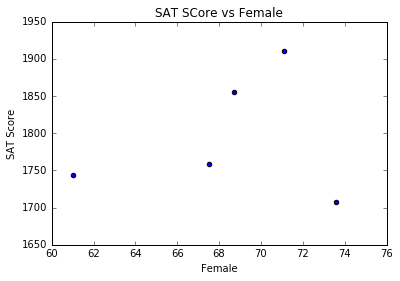

In [36]:
plt.scatter(female_less_sat_greater["female_per"],female_less_sat_greater["sat_score"])
plt.xlabel("Female")
plt.ylabel("SAT Score")
plt.title("SAT SCore vs Female")

one thing that schools has in common is they offer Advanced Placement.
one of those schools counts one of the best schools in US. they offer a very Good program for the students. 
in the schools students take an Advanced Placment test we say if the student have high an AP test Score it make senes that he wil have good score in the SAT Score

**Advanced Placement: **
AP tests are scored on a 1 to 5 scale as follows:[17]

5 – Extremely well qualified
4 – Well qualified
3 – Qualified
2 – Possibly qualified
1 – No recommendation

**Eleanor Roosevelt High School (New York City)**


- the school selects 125 to 140 students out of over 6,000 applicants and is often selected over specialized high schools by students looking for a more liberal curriculum. In 2015, Eleanor Roosevelt High School was ranked the 116th best public high school in the nation by U.S. News & World Report.[1]

**Bard High School Early College**


- BHSEC's admissions processes are extremely competitive, having an overall acceptance rate of 2.5%. Applicants are required to sit for a special BHSEC-only entrance exam. Based on their performance from the exam, and the school's own academic requirements, students are called for one on one interviews. As of 2020, there were 40 applicants per seat.
- All of the Bard High School Early Colleges are tuition-free, public high schools. Each campus has its own admissions practices, but all employ an open-ended writing assessment and an in-person interview. Admissions guidelines for each campus can be found on the schools' websites. Exam preparation for the assessment is also not available.

**Townsend Harris High School**

- Townsend Harris consistently ranks as among the top 100 high schools in the United States.
- In sharp contrast with the original school which was open to male students only, the new school has been dominated by female   students from its inception, today comprising approximately 70% of the student population.[5]

-  As of 2006, the school's minority population is largely Asian, with the New York City Department of Education's "Asian and other" category making up 44% of the student body total, comprising the largest segment of the school's population. White students comprise 37% of the population, Hispanic students 12% and black students 7%.[6]
 The school maintains a 100% graduation rate


In [37]:
ap_per = combined["AP Test Takers "]/combined["total_enrollment"]
ap_per

0      0.305756
1      0.098985
2      0.031773
3      0.351577
4      0.158091
5      0.209123
6      0.741545
7      0.297988
8      0.376177
9      0.307945
10     0.050725
11     0.229698
12     0.093126
13     0.080128
14     0.384014
15     0.341346
16     0.260664
17     0.297988
18     0.388641
19     0.424437
20     0.528807
21     0.152798
22     0.039841
23     0.180556
24     0.196891
25     0.295938
26     0.305720
27     0.137380
28     0.306482
29     0.115385
         ...   
333    0.029536
334    0.084567
335    0.877747
336    0.053398
337    0.268251
338    0.260664
339    0.307945
340    0.082513
341    0.119905
342    0.142857
343    0.055616
344    0.127682
345    0.143466
346    0.293247
347    0.242535
348    0.316247
349    0.123853
350    0.036117
351    0.090191
352    0.096787
353    0.102194
354    0.086031
355    0.191154
356    0.478261
357    0.356433
358    0.077558
359    0.297301
360    0.190955
361    0.026616
362    0.073593
Length: 363, dtype: floa

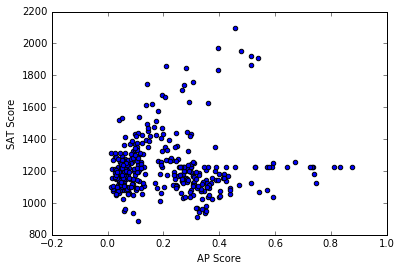

In [39]:
plt.scatter(ap_per,combined["sat_score"])
plt.xlabel("AP Score")
plt.ylabel("SAT Score")
plt.show()

it seems that has three direction one are going up one stying the same and alot are clustred between 1300 and 1000